In [1]:
import math
import numpy as np
import pandas as pd

# import scikitplot
import seaborn as sns
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report

import tensorflow as tf
from tensorflow.keras import optimizers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense, Conv2D, MaxPooling2D
from tensorflow.keras.layers import Dropout, BatchNormalization, LeakyReLU, Activation
from tensorflow.keras.callbacks import Callback, EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.utils import to_categorical

import np_utils

C:\Users\cig79850\AppData\Local\Temp\ipykernel_153144\2540131726.py:3: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [2]:
df = pd.read_csv(r'C:\Users\cig79850\Deep_Learning_Class\main_project\challenges-in-representation-learning-facial-expression-recognition-challenge\icml_face_data.csv')
print(df.shape) # (35887, 3)

df.head()

(35887, 3)


,emotion,Usage,pixels
0,0,Training,70 80 82 72 58 58 60 63 54 58 60 48 89 115 121...
1,0,Training,151 150 147 155 148 133 111 140 170 174 182 15...
2,2,Training,231 212 156 164 174 138 161 173 182 200 106 38...
3,4,Training,24 32 36 30 32 23 19 20 30 41 21 22 32 34 21 1...
4,6,Training,4 0 0 0 0 0 0 0 0 0 0 0 3 15 23 28 48 50 58 84...


In [3]:
df.emotion.unique() # array([0, 2, 4, 6, 3, 5, 1])

df.emotion.value_counts()

# sns.countplot(df.emotion)
# pyplot.show()

emotion
3    8989
6    6198
4    6077
2    5121
0    4953
5    4002
1     547
Name: count, dtype: int64

In [4]:
df.columns

Index(['emotion', 'Usage', 'pixels'], dtype='object')

In [5]:
emotion_label_to_text = {
  0: 'anger',
  1: 'disgust',
  2: 'fear',
  3: 'happiness',
  4: 'sadness',
  5: 'surprise',
  6: 'neutral'
}

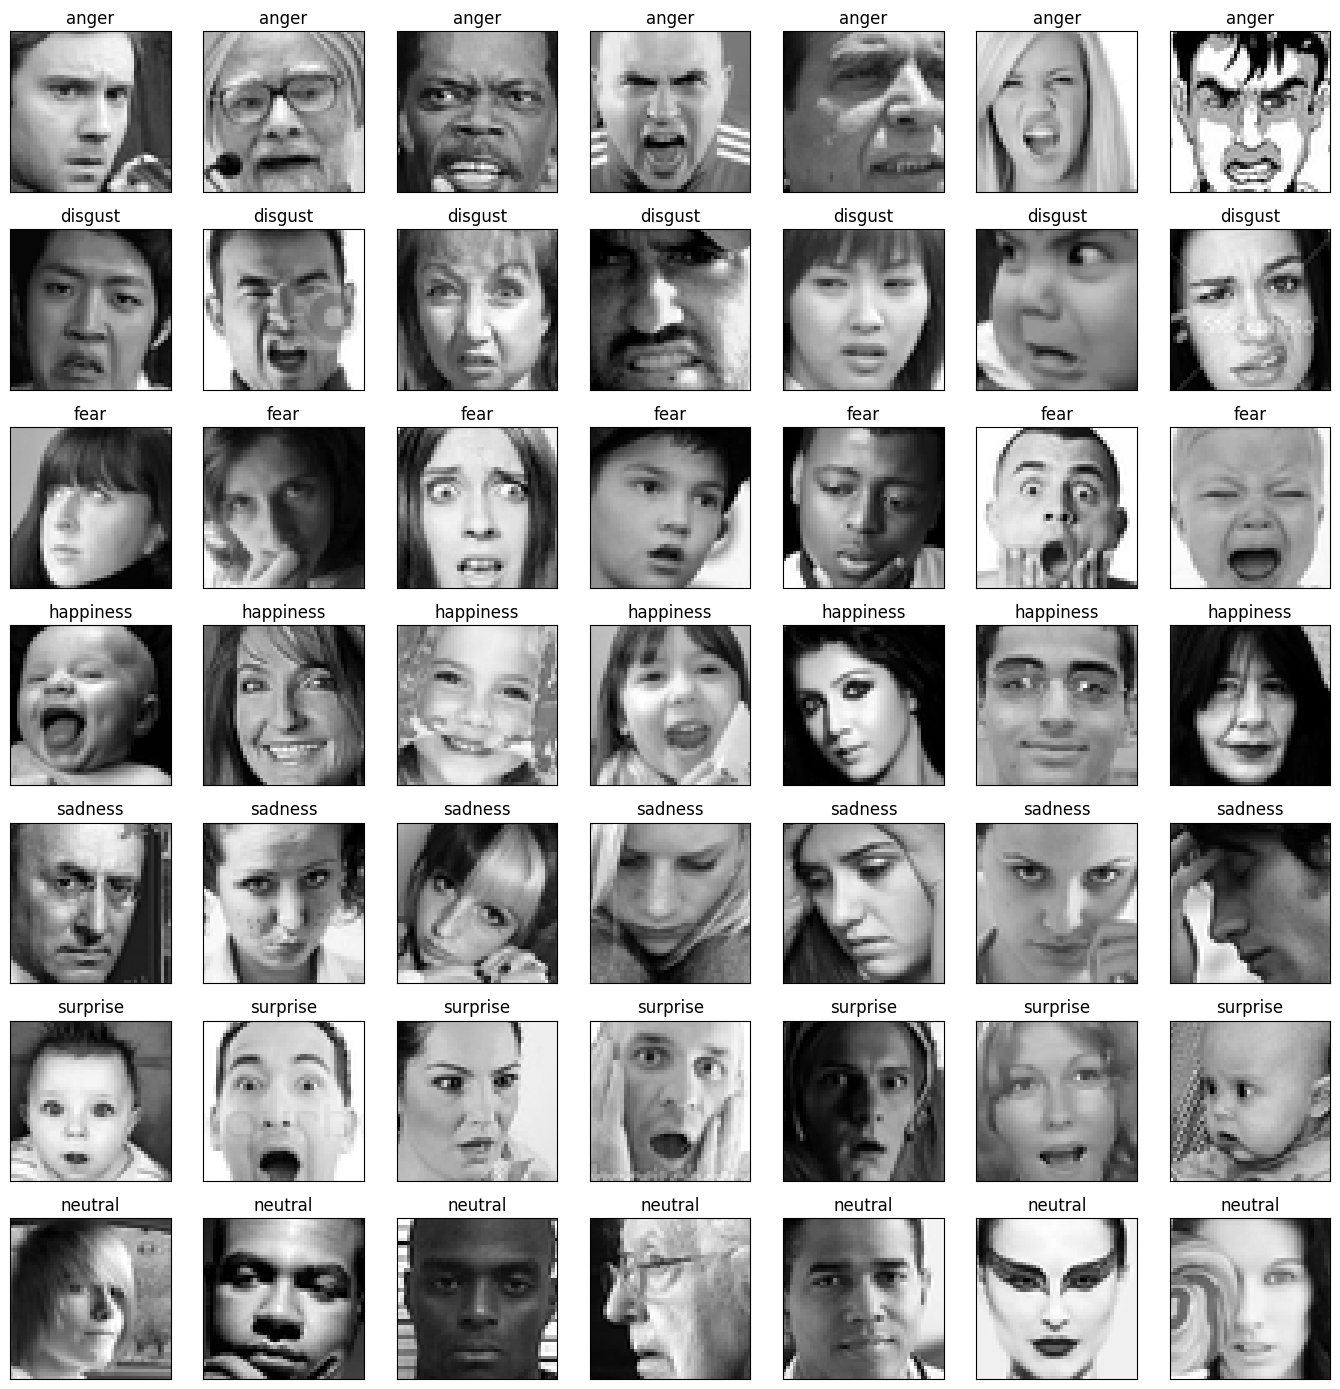

In [6]:
fig = pyplot.figure(1, (14, 14))

k = 0
for label in sorted(df.emotion.unique()):
    for j in range(7):
        px = df[df.emotion==label].pixels.iloc[k]
        px = np.array(px.split(' ')).reshape(48, 48).astype('float32')

        k += 1
        ax = pyplot.subplot(7, 7, k)
        ax.imshow(px, cmap='gray')
        ax.set_xticks([])
        ax.set_yticks([])
        ax.set_title(emotion_label_to_text[label])
        pyplot.tight_layout()

In [7]:
img_array = df.pixels.apply(lambda x: np.array(x.split(' ')).reshape(48, 48, 1).astype('float32'))
img_array = np.stack(img_array, axis=0)
img_array.shape # (21264, 48, 48, 1)

le = LabelEncoder()
img_labels = le.fit_transform(df.emotion)
img_labels = to_categorical(img_labels)
img_labels.shape # (21264, 3)

le_name_mapping = dict(zip(le.classes_, le.transform(le.classes_)))
le_name_mapping # {3: 0, 4: 1, 6: 2}

{0: 0, 1: 1, 2: 2, 3: 3, 4: 4, 5: 5, 6: 6}

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
  img_array,
  img_labels,
  shuffle=True, 
  stratify=img_labels,
  test_size=0.1, 
  random_state=42
)

del df
del img_array
del img_labels

print(X_train.shape, X_valid.shape, y_train.shape, y_valid.shape)


(32298, 48, 48, 1) (3589, 48, 48, 1) (32298, 7) (3589, 7)


In [9]:
# Normalizing arrays, as neural networks are very sensitive to unnormalized data.
X_train = X_train / 255.
X_valid = X_valid / 255.

img_width = X_train.shape[1]
img_height = X_train.shape[2]
img_depth = X_train.shape[3]
num_classes = y_train.shape[1]

In [10]:
from keras.applications import ResNet50
from keras.models import Model

def preprocess_images(X):
    # Repeat the single channel along the last axis to convert to 3 channels
    return np.repeat(X, 3, axis=-1)

# Preprocess the images
X_train_processed = preprocess_images(X_train)
X_valid_processed = preprocess_images(X_valid)

# Build and compile the model
base_model = ResNet50(weights='imagenet', include_top=False, input_shape=(img_width, img_height, 3))
x = Flatten()(base_model.output)
x = Dense(128, activation='relu', name='dense_1')(x)
x = Dropout(0.5, name='dropout_1')(x)
output = Dense(num_classes, activation='softmax', name='out_layer')(x)



In [11]:
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    min_delta=0.00005,
    patience=11,
    verbose=1,
    restore_best_weights=True,
)

lr_scheduler = ReduceLROnPlateau(
    monitor='val_accuracy',
    factor=0.5,
    patience=7,
    min_lr=1e-7,
    verbose=1,
)

callbacks = [
    early_stopping,
    lr_scheduler,
]

In [12]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.15,
    height_shift_range=0.15,
    shear_range=0.15,
    zoom_range=0.15,
    horizontal_flip=True,
)

train_datagen.fit(X_train)

In [13]:
batch_size = 32 #batch size of 32 performs the best.

epochs = 100

# optims = [
#   optimizers.Nadam(
#       learning_rate=0.001,
#       beta_1=0.9,
#       beta_2=0.999,
#       epsilon=1e-07,
#       name='Nadam'),
    
#   optimizers.Adam(0.001),
# ]

In [14]:
from keras.optimizers import Adam

# Define optimizer
optimizer = Adam(learning_rate=0.001)

# Build and compile the model
model = Model(inputs=base_model.input, outputs=output)
model.compile(loss='categorical_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Train the model
history = model.fit(
    train_datagen.flow(X_train_processed, y_train, batch_size=batch_size),
    validation_data=(X_valid_processed, y_valid),
    steps_per_epoch=len(X_train) / batch_size,
    epochs=epochs,
    callbacks=callbacks
)


Epoch 1/100


1009/1009 [==============================] - 402s 385ms/step - loss: 1.6949 - accuracy: 0.3452 - val_loss: 1.5804 - val_accuracy: 0.3934 - lr: 0.0010
Epoch 2/100
1009/1009 [==============================] - 355s 352ms/step - loss: 1.6061 - accuracy: 0.3706 - val_loss: 1.7295 - val_accuracy: 0.3352 - lr: 0.0010
Epoch 3/100
1009/1009 [==============================] - 354s 351ms/step - loss: 1.6415 - accuracy: 0.3605 - val_loss: 1.7969 - val_accuracy: 0.2784 - lr: 0.0010
Epoch 4/100
1009/1009 [==============================] - 359s 356ms/step - loss: 1.6653 - accuracy: 0.3431 - val_loss: 1.5803 - val_accuracy: 0.3722 - lr: 0.0010
Epoch 5/100
1009/1009 [==============================] - 354s 351ms/step - loss: 1.5355 - accuracy: 0.4002 - val_loss: 1.8596 - val_accuracy: 0.1856 - lr: 0.0010
Epoch 6/100
1009/1009 [==============================] - 355s 352ms/step - loss: 1.5380 - accuracy: 0.3982 - val_loss: 1.6541 - val_accuracy: 0.3670 - lr: 0.0010
Epoch 7/100
1009/1009 [===

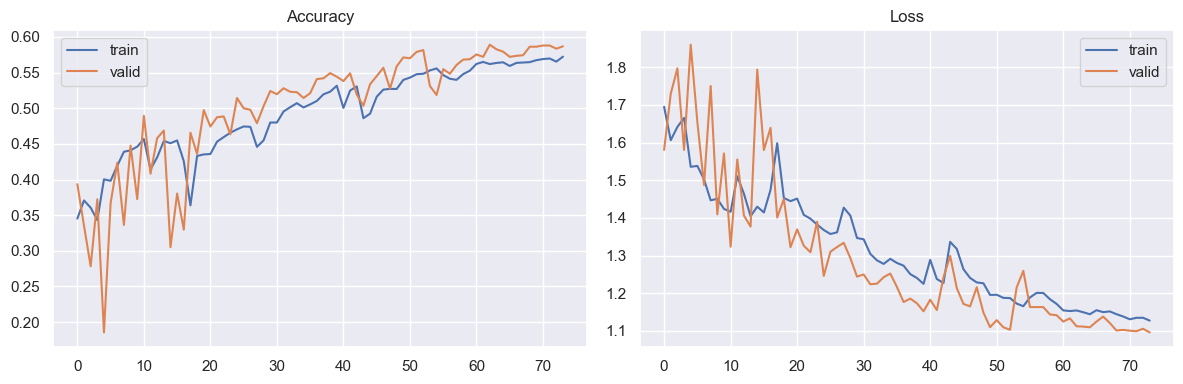

In [15]:
import matplotlib.pyplot as plt

sns.set()
fig, axes = plt.subplots(1, 2, figsize=(12, 4))

# Plot Accuracy
ax = axes[0]
sns.lineplot(x=history.epoch, y=history.history['accuracy'], ax=ax, label='train')
sns.lineplot(x=history.epoch, y=history.history['val_accuracy'], ax=ax, label='valid')
ax.set_title('Accuracy')

# Plot Loss
ax = axes[1]
sns.lineplot(x=history.epoch, y=history.history['loss'], ax=ax, label='train')
sns.lineplot(x=history.epoch, y=history.history['val_loss'], ax=ax, label='valid')
ax.set_title('Loss')

plt.tight_layout()
plt.savefig('epoch_history_dcnn.png')
plt.show()


In [16]:
import time
from keras.models import model_from_json

# Get timestamp
timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")

# Save model architecture as JSON
model_json = model.to_json()
json_filename = f"model_{timestamp}.json"
with open(json_filename, "w") as json_file:
    json_file.write(model_json)

# Save model weights
h5_filename = f"model_{timestamp}.h5"
model.save_weights(h5_filename)

# Save entire model (architecture + weights)
model.save(f"model_{timestamp}.h5")


C:\ProgramData\anaconda3\envs\dlenv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


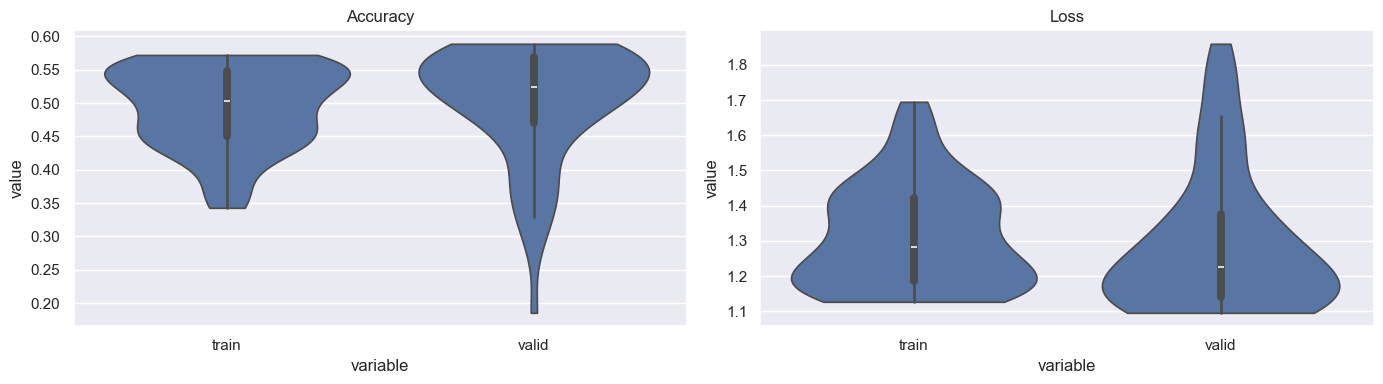

In [17]:
import time
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

# Create DataFrames for accuracy and loss
df_accu = pd.DataFrame({'train': history.history['accuracy'], 'valid': history.history['val_accuracy']})
df_loss = pd.DataFrame({'train': history.history['loss'], 'valid': history.history['val_loss']})

# Get timestamp
timestamp = time.strftime("%Y-%m-%d_%H-%M-%S")

# Create violin plots for accuracy and loss
fig, axes = plt.subplots(1, 2, figsize=(14, 4))

sns.violinplot(x="variable", y="value", data=pd.melt(df_accu), cut=0, ax=axes[0])
axes[0].set_title('Accuracy')

sns.violinplot(x="variable", y="value", data=pd.melt(df_loss), cut=0, ax=axes[1])
axes[1].set_title('Loss')

plt.tight_layout()

# Save the plot
plt.savefig(f'performance_dist_{timestamp}.png')

# Show the plot
plt.show()


113/113 [==============================] - 7s 65ms/step


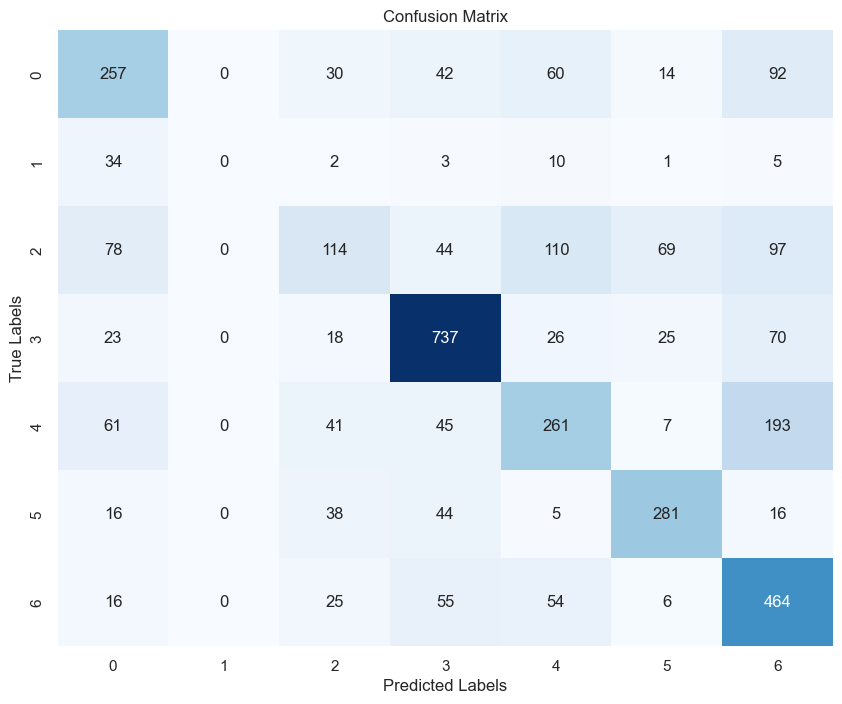

In [21]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Assuming you have predictions for the test set
y_pred = model.predict(X_valid_processed)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_valid, axis=1)  # Assuming y_test is one-hot encoded

# Create confusion matrix
conf_mat = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues', cbar=False)
plt.title('Confusion Matrix')
plt.xlabel('Predicted Labels')
plt.ylabel('True Labels')
plt.show()

1/1 [==============================] - 0s 58ms/step


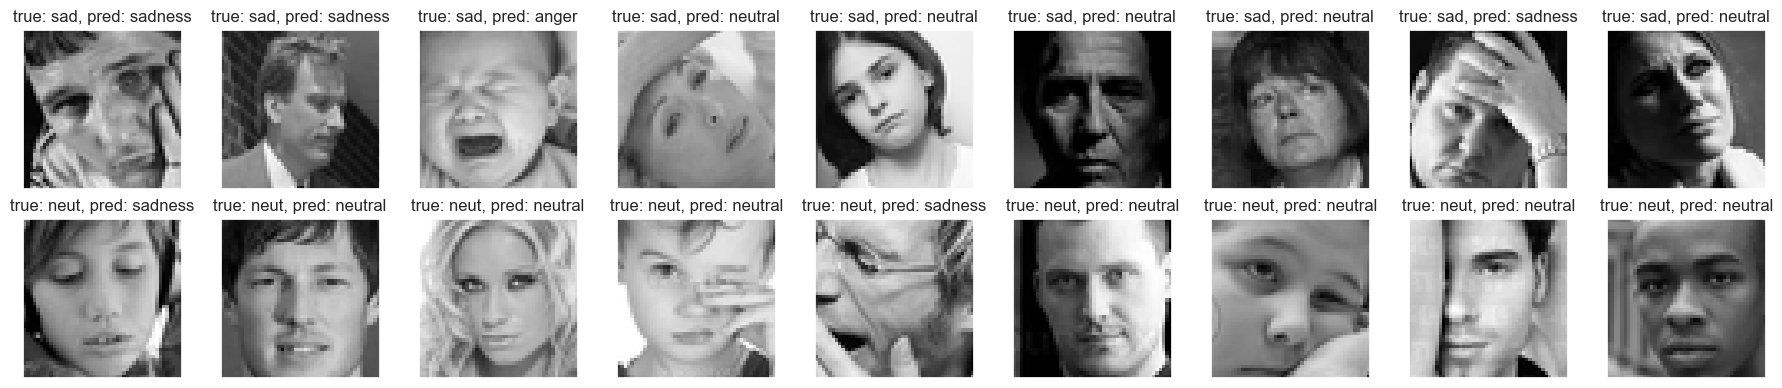

In [19]:
from keras.models import Model
from keras.layers import Flatten, Dense, Dropout
import numpy as np
import matplotlib.pyplot as plt

# Assuming X_valid_processed is the preprocessed grayscale images

mapper = {
    0: 'anger',
    1: 'disgust',
    2: 'fear',
    3: 'happiness',
    4: 'sadness',
    5: 'surprise',
    6: 'neutral'
}

np.random.seed(2)
random_sad_imgs = np.random.choice(np.where(y_valid[:, 4]==1)[0], size=9)
random_neutral_imgs = np.random.choice(np.where(y_valid[:, 6]==1)[0], size=9)

fig = plt.figure(1, (18, 4))

for i, (sadidx, neuidx) in enumerate(zip(random_sad_imgs, random_neutral_imgs)):
    ax = plt.subplot(2, 9, i+1)
    sample_img = X_valid_processed[sadidx, :, :, 0]  # Assuming X_valid_processed is grayscale
    sample_img_rgb = np.repeat(sample_img[..., np.newaxis], 3, axis=-1)  # Convert grayscale to RGB
    ax.imshow(sample_img_rgb, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Predict probabilities for the current image
    pred_probs_sad = model.predict(sample_img_rgb.reshape(1, 48, 48, 3))  # Reshape to include 3 channels

    # Select the class with the highest probability
    pred_label_sad = np.argmax(pred_probs_sad)

    ax.set_title(f"true: sad, pred: {mapper[pred_label_sad]}")

    ax = plt.subplot(2, 9, i+10)
    sample_img = X_valid_processed[neuidx, :, :, 0]  # Assuming X_valid_processed is grayscale
    sample_img_rgb = np.repeat(sample_img[..., np.newaxis], 3, axis=-1)  # Convert grayscale to RGB
    ax.imshow(sample_img_rgb, cmap='gray')
    ax.set_xticks([])
    ax.set_yticks([])

    # Predict probabilities for the current image
    pred_probs_neut = model.predict(sample_img_rgb.reshape(1, 48, 48, 3))  # Reshape to include 3 channels

    # Select the class with the highest probability
    pred_label_neut = np.argmax(pred_probs_neut)

    ax.set_title(f"true: neut, pred: {mapper[pred_label_neut]}")

plt.tight_layout()
plt.show()
